In [ ]:
from sklearn.cluster import DBSCAN
import json
from pathlib import Path
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import re
import hdbscan
from sklearn.metrics.pairwise import cosine_distances
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Load dữ liệu


In [ ]:
with open ("../../../data/processed_data/processed_data_dash.json", "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data)
documents = df['content_clean'].to_list()
print(f"Số bài báo trong tập dữ liệu: {len(documents)}")

Số bài báo trong tập dữ liệu: 7831


In [ ]:
# Loại bỏ kí tự chữ số
def remove_numbers(text):
    return re.sub(r'\d+', '', text)
documents = [remove_numbers(doc) for doc in documents]



## Text embedding

In [ ]:
model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')
embeddings = model.encode(
    documents,
    batch_size=4,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True  # chuẩn hoá L2 -> phù hợp cosine
)
print("Embeddings shape:", embeddings.shape)

## Text clustering

### Tìm số lượng cụm tối ưu

In [ ]:
candidate_k = [8,9,10,11,12,13,14,15,16,17,18]
scores = {}
for k in candidate_k:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels_tmp = km.fit_predict(embeddings)
    sil = silhouette_score(embeddings, labels_tmp, metric="cosine")
    scores[k] = sil
    print(f"Số cụm: {k}, silhouette score: {sil:.4f}")
best_k = max(scores, key=scores.get)
print("\n=> Số lượng cụm tốt nhất:", best_k)

Silhouette per k: {8: np.float32(0.099353075), 9: np.float32(0.09938931), 10: np.float32(0.096321486), 11: np.float32(0.09409548), 12: np.float32(0.09422683), 13: np.float32(0.077859715), 14: np.float32(0.07942095), 15: np.float32(0.08370905), 16: np.float32(0.081623755), 17: np.float32(0.08298157), 18: np.float32(0.084355675)} => best_k: 9


In [ ]:
# Hàm tính toán MSE
def compute_mse(embeddings, labels):
    mse_list = []
    for cl in np.unique(labels):
        if cl == -1:
            continue

        idx = np.where(labels == cl)[0]
        if len(idx) == 0:
            continue

        cluster_points = embeddings[idx]
        centroid = np.mean(cluster_points, axis=0)
        sq_dists = np.sum((cluster_points - centroid) ** 2, axis=1)

        mse = np.mean(sq_dists)
        mse_list.append(mse)
        print(f"Cụm {cl}: MSE={mse:.4f}, số văn bản={len(idx)}")

    if mse_list:
        avg_mse = np.mean(mse_list)
        print("MSE trung bình =", avg_mse)
        return avg_mse
    else:
        print("Không có cụm nào (toàn noise)")
        return None

### K-means

In [ ]:
# Huấn luyện KMeans cuối cùng với best_k
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)
compute_mse(embeddings, kmeans_labels)

Cụm 0: MSE=0.1407, số văn bản=1044
Cụm 1: MSE=0.1454, số văn bản=978
Cụm 2: MSE=0.1117, số văn bản=1047
Cụm 3: MSE=0.1006, số văn bản=592
Cụm 4: MSE=0.1225, số văn bản=743
Cụm 5: MSE=0.1188, số văn bản=613
Cụm 6: MSE=0.1480, số văn bản=968
Cụm 7: MSE=0.1206, số văn bản=759
Cụm 8: MSE=0.1464, số văn bản=1137
MSE trung bình = 0.12829593


np.float32(0.12829593)

### HDBSCAN

In [ ]:
cosine_distance_matrix = cosine_distances(embeddings).astype(np.float64)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='precomputed')
hdbscan_labels = clusterer.fit_predict(cosine_distance_matrix)
compute_mse(embeddings, hdbscan_labels)

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Cụm 0: MSE=0.0330, số văn bản=6
Cụm 1: MSE=0.0325, số văn bản=7
Cụm 2: MSE=0.0627, số văn bản=5
Cụm 3: MSE=0.0478, số văn bản=9
Cụm 4: MSE=0.0617, số văn bản=7
Cụm 5: MSE=0.0657, số văn bản=9
Cụm 6: MSE=0.0876, số văn bản=13
Cụm 7: MSE=0.0597, số văn bản=6
Cụm 8: MSE=0.0434, số văn bản=11
Cụm 9: MSE=0.0486, số văn bản=7
Cụm 10: MSE=0.0751, số văn bản=13
Cụm 11: MSE=0.0751, số văn bản=5
Cụm 12: MSE=0.0691, số văn bản=62
Cụm 13: MSE=0.0708, số văn bản=34
Cụm 14: MSE=0.0741, số văn bản=20
Cụm 15: MSE=0.0616, số văn bản=11
Cụm 16: MSE=0.0443, số văn bản=6
Cụm 17: MSE=0.0685, số văn bản=6
Cụm 18: MSE=0.0432, số văn bản=11
Cụm 19: MSE=0.0435, số văn bản=8
Cụm 20: MSE=0.0411, số văn bản=7
Cụm 21: MSE=0.0568, số văn bản=8
Cụm 22: MSE=0.0657, số văn bản=11
Cụm 23: MSE=0.0437, số văn bản=5
Cụm 24: MSE=0.0712, số văn bản=13
Cụm 25: MSE=0.0635, số văn bản=5
Cụm 26: MSE=0.0611, số văn bản=13
Cụm 27: MSE=0.0710, số văn bản=13
Cụm 28: MSE=0.0509, số văn bản=6
Cụm 29: MSE=0.0463, số văn bản=17
Cụm 30:

np.float32(0.0554426)

### Hierarchial

In [ ]:
hierarchial = AgglomerativeClustering(n_clusters=best_k, metric="euclidean", linkage="ward")
hierarchial_labels = hierarchial.fit_predict(embeddings)
compute_mse(embeddings, hierarchial_labels)

Cụm 0: MSE=0.1500, số văn bản=1703
Cụm 1: MSE=0.1491, số văn bản=943
Cụm 2: MSE=0.1238, số văn bản=773
Cụm 3: MSE=0.1473, số văn bản=1140
Cụm 4: MSE=0.1202, số văn bản=644
Cụm 5: MSE=0.0854, số văn bản=435
Cụm 6: MSE=0.1247, số văn bản=608
Cụm 7: MSE=0.1091, số văn bản=897
Cụm 8: MSE=0.1415, số văn bản=738
MSE trung bình = 0.12790295


np.float32(0.12790295)

## Trích xuất top từ khóa

In [ ]:
# Rút trích từ khóa đại diện bằng TF-IDF (chỉ để diễn giải, không dùng phân cụm)
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7,
    analyzer="word"
)

X_tfidf = tfidf.fit_transform(documents)
feature_names = tfidf.get_feature_names_out()

def top_terms_per_cluster(X_tfidf, labels, feature_names, topn=15):
    k = labels.max() + 1
    means = np.zeros((k, X_tfidf.shape[1]), dtype=np.float32)
    for c in range(k):
        rows = X_tfidf[labels == c]
        if rows.shape[0] > 0:
            means[c] = rows.mean(axis=0).A1  # vector TF-IDF trung bình mỗi cụm
    
    tops = []
    for c in range(k):
        idx = np.argsort(means[c])[::-1][:topn]
        tops.append([feature_names[i] for i in idx])
    return tops


top_terms = top_terms_per_cluster(X_tfidf, kmeans_labels, feature_names, topn=15)

# In từ khóa đại diện
for c, terms in enumerate(top_terms):
    print(f"\n=== Cụm {c} ({(kmeans_labels==c).sum()} bài) ===")
    print(", ".join(terms))




=== Cụm 0 (1044 bài) ===
cô, anh, tôi, người, những, con, một, phim, không, khi, diễn_viên, năm, nhiều, khán_giả, để

=== Cụm 1 (978 bài) ===
đồng, tỷ, tăng, doanh_nghiệp, giá, usd, công_ty, thị_trường, cổ_phiếu, tỷ đồng, năm, việt_nam, ngân_hàng, này, từ

=== Cụm 2 (1047 bài) ===
công_an, bị_cáo, điều_tra, người, tỉnh, đã, đối_tượng, bị, tiền, cảnh_sát, án, xã, hành_vi, đồng, vụ

=== Cụm 3 (592 bài) ===
ukraine, nga, tổng_thống, trump, ông, cuộc, mỹ, putin, ông trump, zelensky, đã, uav, tên_lửa, một, sẽ

=== Cụm 4 (743 bài) ===
trận, giải, đấu, nữ, đội, việt_nam, đội_tuyển, cầu_thủ, bóng, nữ việt_nam, vô_địch, trận đấu, thi_đấu, bóng_chuyền, hlv

=== Cụm 5 (613 bài) ===
điểm, trường, đại_học, thi, thí_sinh, ngành, học_sinh, điểm chuẩn, chuẩn, thpt, trường đại_học, học, tốt_nghiệp, giáo_dục, sinh_viên

=== Cụm 6 (968 bài) ===
bác_sĩ, bệnh, bệnh_nhân, ung_thư, điều_trị, bệnh_viện, có_thể, không, máu, thuốc, y_tế, nguy_cơ, hoặc, phẫu_thuật, tim

=== Cụm 7 (759 bài) ===
việt_nam, phát_tr

## Lưu kết quả

In [ ]:
# Lưu kết quả phân cụm vào file csv bao gồm title, url, content_clean, cluster
df["cluster"] = kmeans_labels
out_path = "../../../results/models/Text_Clustering/cluster_results.csv"

cols = ["title","url","content_clean"] if set(["title","url","content_clean"]).issubset(df.columns) else df.columns.tolist()
df_out = df[cols].assign(cluster=kmeans_labels)
df_out.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Đã lưu:", out_path)

Đã lưu: /content/drive/MyDrive/CTAI_ML_project/cluster_results.csv


In [ ]:
joblib.dump(kmeans, "../../../results/models/Text_Clustering/weights/kmeans_model.pkl")
print("Đã lưu mô hình KMeans.")

Đã lưu mô hình KMeans.


## Trực quan hóa kết quả phân cụm

In [ ]:
# embeddings: np.ndarray (N, d)  -> từ SentenceTransformer
# labels:     np.ndarray (N,)    -> từ KMeans
N = embeddings.shape[0]

# (tuỳ chọn) PCA trước để tăng tốc và khử nhiễu nhẹ
use_pca_pre = True
pca_dims = min(100, embeddings.shape[1])  # 100 là lựa chọn phổ biến cho UMAP
if use_pca_pre:
    pca = PCA(n_components=pca_dims, random_state=42)
    X_umap = pca.fit_transform(embeddings)
else:
    X_umap = embeddings

def pick_neighbors(n):
    return int(np.clip(np.sqrt(n), 5, 100))

n_neighbors = pick_neighbors(N)
min_dist = 0.005
metric = "cosine"

print(f"UMAP params -> n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}, N={N}")

UMAP params -> n_neighbors=88, min_dist=0.005, metric=cosine, N=7881


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.005, n_jobs=1, n_neighbors=88, random_state=42, verbose=True)
Sun Sep  7 02:39:51 2025 Construct fuzzy simplicial set
Sun Sep  7 02:39:51 2025 Finding Nearest Neighbors
Sun Sep  7 02:39:51 2025 Building RP forest with 9 trees
Sun Sep  7 02:39:51 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Sun Sep  7 02:40:02 2025 Finished Nearest Neighbor Search
Sun Sep  7 02:40:03 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Sep  7 02:40:45 2025 Finished embedding


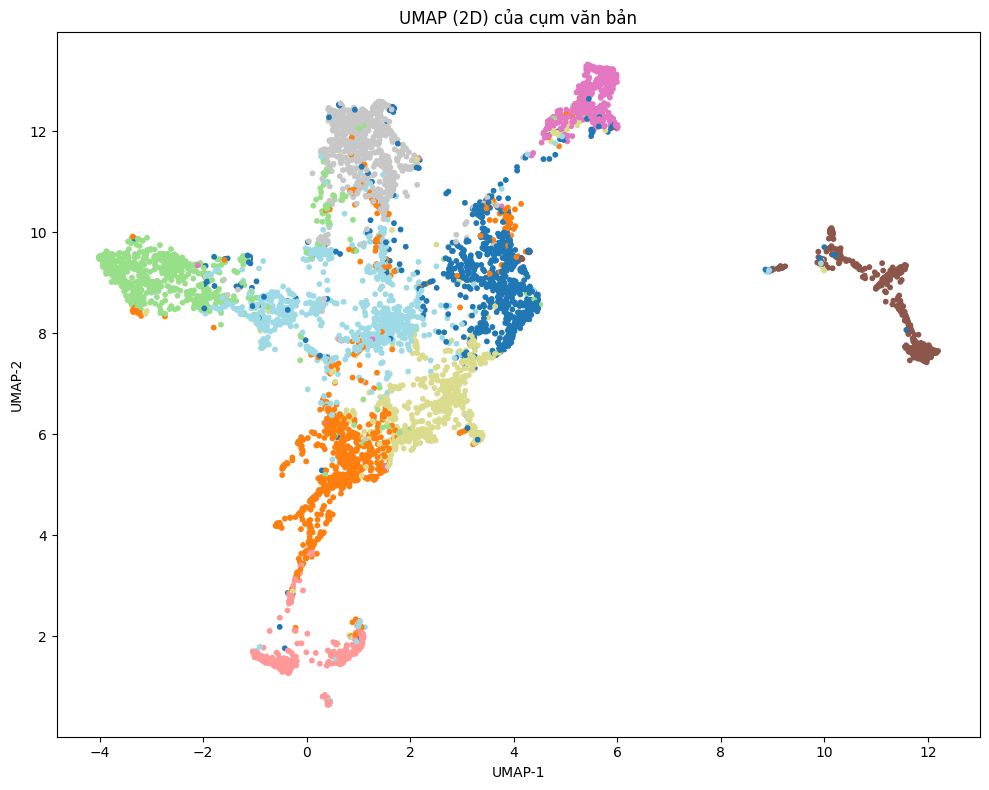

In [ ]:
# --------- UMAP 2D ----------
reducer2d = umap.UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
    random_state=42,
    n_jobs=-1,                 # dùng đa luồng nếu có
    verbose=True
)
U2 = reducer2d.fit_transform(X_umap)  # (N,2)

plt.figure(figsize=(10, 8))
plt.scatter(U2[:, 0], U2[:, 1], c=kmeans_labels, s=10, cmap="tab20")
plt.title("UMAP (2D) của cụm văn bản")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.savefig("../../../results/models/Text_Clustering/figures/umap_2d.png", dpi=200)
plt.show()




/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.005, n_components=3, n_jobs=1, n_neighbors=88, random_state=42, verbose=True)
Sun Sep  7 02:40:51 2025 Construct fuzzy simplicial set
Sun Sep  7 02:40:51 2025 Finding Nearest Neighbors
Sun Sep  7 02:40:51 2025 Building RP forest with 9 trees
Sun Sep  7 02:40:51 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Sun Sep  7 02:40:58 2025 Finished Nearest Neighbor Search
Sun Sep  7 02:40:58 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Sep  7 02:41:25 2025 Finished embedding


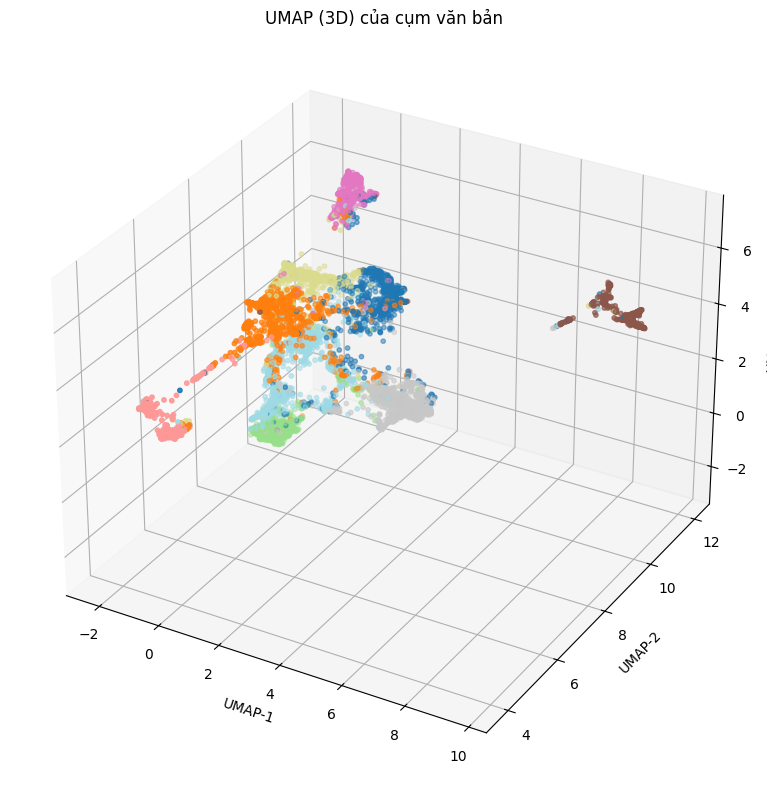

In [ ]:
# --------- UMAP 3D ----------
reducer3d = umap.UMAP(
    n_components=3,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
    random_state=42,
    n_jobs=-1,
    verbose=True
)
U3 = reducer3d.fit_transform(X_umap)  # (N,3)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(U3[:, 0], U3[:, 1], U3[:, 2], c=kmeans_labels, s=10, cmap="tab20")
ax.set_title("UMAP (3D) của cụm văn bản")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.savefig("../../../results/models/Text_Clustering/figures/umap_3d.png", dpi=200)
plt.show()



In [ ]:
# --------- (Tuỳ chọn) Lưu toạ độ UMAP ----------
umap_df = pd.DataFrame({
    "umap2_x": U2[:, 0], "umap2_y": U2[:, 1],
    "umap3_x": U3[:, 0], "umap3_y": U3[:, 1], "umap3_z": U3[:, 2],
    "cluster": kmeans_labels
})
if "title" in df.columns: umap_df["title"] = df["title"]
if "url" in df.columns:   umap_df["url"]   = df["url"]

umap_out = Path("../../../results/models/Text_Clustering/umap_coords.csv")
umap_df.to_csv(umap_out, index=False, encoding="utf-8-sig")
print("Đã lưu toạ độ UMAP:", umap_out)

Đã lưu toạ độ UMAP: /content/drive/MyDrive/CTAI_ML_project/umap_coords.csv


## Inference

In [ ]:

def get_embedding_e5(text):
    """Generates embedding for a given text using the specified model."""
    return model_embedding.encode(
        [text],
        convert_to_numpy=True,
        normalize_embeddings=True
    )[0]

def suggest_cluster_and_articles(text, kmeans, embeddings, df, topn=5):
    """
    Suggests the cluster and top articles related to a given text.

    Args:
        text (str): The input text.
        kmeans (KMeans): The trained KMeans model.
        embeddings (np.ndarray): The embeddings of the documents used for clustering (N, 768).
        df (pd.DataFrame): The DataFrame containing the documents with 'title', 'url', and 'cluster' columns.
        topn (int): The number of top articles to suggest.

    Returns:
        tuple: A tuple containing the predicted cluster ID and a DataFrame of suggested articles.
    """
    # Get embedding for the input text using the same model as training
    emb = get_embedding_e5(text).reshape(1, -1)

    # Predict the cluster for the input text
    cluster_id = model_cluster.predict(emb)[0]
    print(f"Đoạn văn bản thuộc cụm: {cluster_id}")

    # Filter documents belonging to the predicted cluster
    cluster_docs = df[df["cluster"] == cluster_id].copy()

    # Get the indices of the documents in the predicted cluster
    cluster_indices = cluster_docs.index

    # Retrieve the embeddings for the documents in the predicted cluster
    cluster_embeddings = embeddings[cluster_indices]

    # Calculate cosine similarity between the input text embedding and the embeddings of documents in the cluster
    sims = cosine_similarity(emb, cluster_embeddings)[0]
    cluster_docs = cluster_docs.assign(score=sims)

    # Sort documents by similarity score in descending order
    cluster_docs = cluster_docs.sort_values("score", ascending=False)

    # Print and return the top articles
    print(f"\nTop {topn} bài báo liên quan trong Cụm {cluster_id}:")
    for i, row in cluster_docs.head(topn).iterrows():
        print(f"- {row.get('title','(no title)')} | URL: {row.get('url')} | score={row['score']:.3f}")

    return cluster_id, cluster_docs.head(topn)

In [ ]:
# Load the trained KMeans model
model_cluster = joblib.load("../../../results/models/Text_Clustering/weights/kmeans_model.pkl")

# Load the same embedding model used for training KMeans
model_embedding = SentenceTransformer('intfloat/multilingual-e5-large-instruct')



# === Test ===
test_text = "Putin tham dự lễ duyệt binh lớn chưa từng có tại Trung Quốc"
cluster_id, suggestions = suggest_cluster_and_articles(
    test_text,
    kmeans= model_cluster,              # mô hình KMeans bạn đã train
    embeddings=embeddings,      # ma trận embedding (N, 768)
    df=df,                      # DataFrame gốc có cột url, title
    topn=5
)

Đoạn văn bản thuộc cụm: 3

Top 5 bài báo liên quan trong Cụm 3:
- Tổng thống Putin xúc động viếng bạn học cũ, Chánh án Tòa Tối cao Nga | URL: https://dantri.com.vn/the-gioi/tong-thong-putin-xuc-dong-vieng-ban-hoc-cu-chanh-an-toa-toi-cao-nga-20250724204948220.htm | score=0.839
- Ông Kim Jong-un lên tiếng về chiến công của lực lượng Triều Tiên ở Nga | URL: https://dantri.com.vn/the-gioi/ong-kim-jong-un-len-tieng-ve-chien-cong-cua-luc-luong-trieu-tien-o-nga-20250821065950868.htm | score=0.839
- Ông Putin ca ngợi 'tinh thần hy sinh' của quân nhân Triều Tiên ở Kursk | URL: https://vnexpress.net/ong-putin-ca-ngoi-tinh-than-hy-sinh-cua-quan-nhan-trieu-tien-o-kursk-4926147.html | score=0.839
- Tổng thống Nga Putin làm điều đặc biệt trước khi lên máy bay rời Alaska | URL: https://vietnamnet.vn/tong-thong-nga-putin-lam-dieu-dac-biet-truoc-khi-len-may-bay-roi-alaska-2432631.html | score=0.837
- Ông Kim Jong-un ca ngợi quân nhân 'anh hùng' tham chiến ở Nga | URL: https://vnexpress.net/ong-kim-jong